## CNN
Referencing https://becominghuman.ai/building-an-image-classifier-using-deep-learning-in-python-totally-from-a-beginners-perspective-be8dbaf22dd8

### Import relevant modules

In [1]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Reshape, concatenate,  Reshape, Flatten
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, RepeatVector, Permute, Activation,Lambda
from keras.layers import Conv2D, MaxPool2D, Flatten,multiply,SpatialDropout2D
from keras.regularizers import l2
import tensorflow as tf
import keras
import keras.backend as K
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend import clear_session
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.layers import MaxPooling2D, Input, Dense, Flatten ,AveragePooling2D

from keras.optimizers import Adam,rmsprop,SGD

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.initializers import glorot_normal
from keras import regularizers

from keras.layers import Dense
from keras.models import Model
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
import zipfile
from urllib import request
import imutils
import matplotlib.image as mpimg
import random
%matplotlib inline
import cv2
from glob import glob
import keras,math
import cv2 as cv 
import pandas as pd
from keras.models import load_model
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Reshape ,MaxPooling2D, advanced_activations
from keras.layers import concatenate, Concatenate,Dense, Flatten,SeparableConv2D,LeakyReLU,GlobalAveragePooling2D
from keras.layers import BatchNormalization, RepeatVector, Permute, Activation, Reshape, Flatten,Multiply
from keras.layers.advanced_activations import PReLU

from keras.layers import Lambda,Add,Dropout,SpatialDropout2D,DepthwiseConv2D,normalization
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend import clear_session
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.layers import MaxPooling2D, Input, Dense, Flatten,ThresholdedReLU
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec
 
import tensorflow as tf 
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
 
 
 
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add
 

from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add
 
 
from keras.optimizers import Adam 

### Config

In [3]:
di= 256
batch_size = 16


## Functions for the network

In [4]:
def mish(x):
    x=BatchNormalization()(x)
    x4 = Activation('softplus')(x)
    x4=Activation('tanh')(x4)
    y = Lambda(lambda x: x[0]*x[1])([x4,x])
    return y

def swish(x):
    #x=BatchNormalization()(x)
    x1 = Activation('relu')(x)
    x2 = Activation('sigmoid')(x)
    y = Lambda(lambda x: x[0]*x[1])([x2,x])
    return y

def poold(x):
    m=MaxPool2D(pool_size=5, strides=1,padding='same')(x)
    a=AveragePooling2D(pool_size=5, strides=1,padding='same')(x)
    ad=Lambda(lambda x: x[0]+x[1])([m,a])
    av=Lambda(lambda x: x*0.5)(ad)
    y=Lambda(lambda x: x[0]+x[1])([x,av])
 
 
def cnf(z,f):
    return Conv2D(f, kernel_size=5, strides=1,padding='same',activation="relu",kernel_initializer='he_normal',
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(z)

def cnh(z,f,k,s):
    return Conv2D(f, kernel_size=k, strides=s,padding='same',activation="relu",kernel_initializer='he_normal',
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(z)
 
    
def actc(x):      
    x1 = Activation('relu')(x)
    x2 = Activation('sigmoid')(x)
    x3 = Lambda(lambda x: x[0]*x[1])([x2,x])
    x4 = Activation('softplus')(x)
    x4=Activation('tanh')(x4)
    x5 = Lambda(lambda x: x[0]*x[1])([x4,x])
    c1= Conv2D(5, kernel_size=3, strides=1, padding='same', kernel_initializer = 'he_normal')(x1)  
    c2= Conv2D(5, kernel_size=3, strides=1, padding='same', kernel_initializer = 'he_normal')(x3)  
    c3= Conv2D(5, kernel_size=3, strides=1, padding='same', kernel_initializer = 'he_normal')(x5)  
    cx=concatenate([c1,c2,c3], axis = 3)
    #cx= BatchNormalization()(cx) x2=add([x2,cnh(x2,64,1,1)])
    y= Conv2D(3, kernel_size=3, strides=1, padding='same', kernel_initializer = 'he_normal')(cx)
    return y
 
 
 
def rw(input_tensor, features ):
    x = Conv2D(features, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)
    x = Conv2D(features, 3, padding='same')(x)
    return add([input_tensor, x])    


def mdsr2(ix,f):
    x=Conv2D(f, kernel_size=3, strides=1, padding='same', kernel_initializer = 'he_normal')(ix)
    y=actc(ix)
    x1=rw(x,f)
    x1=rw(x1,f)
    x2=rw(x,f)
    x2=rw(x2,f)
    x3=rw(x,f)
    x3=rw(x3,f)
    x=add([x1,x2,x3])
    x=Conv2D(3, kernel_size=3, strides=1, padding='same', kernel_initializer = 'he_normal')(x)
    x=add([x,y ])
    return x 

def unt2(ip,f):
  
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ip)
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    

    conv5 = Conv2D( f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    
    u5=Conv2DTranspose(f, 3, strides=16,activation='relu', padding='same')(drop5)
    u4=Conv2DTranspose(f, 3, strides=8,activation='relu', padding='same')(pool3)
    u3=Conv2DTranspose(f, 3, strides=4,activation='relu', padding='same')(pool2)
    u2=Conv2DTranspose(f, 3, strides=2,activation='relu', padding='same')(pool1)
    u1=Conv2DTranspose(f, 3, strides=1,activation='relu', padding='same')(ip)
    
    
    col = concatenate([u1,u2,u3,u4,u5], axis = 3)
    col = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(col)
    ip = Conv2D(3, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ip)
    sm = add([col,ip])

 
    x = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(sm)
        
 
    return x


### Setup

### Fitting the model using train images

In [5]:
weight_decay = 1e-4
 

input_im = Input(shape=(di, di, 1))
 

x1=cnh(input_im,64,9,4) 
x1=actc(x1) 
y1=unt2(x1,32)
x2=cnh(x1,64,9,1) 
x2=mdsr2(x2,10)
x2=concatenate([y1,x2], axis = 3)
p2 = MaxPooling2D(pool_size=(1, 1))(x2)
p2 = Activation('relu')(p2)
y= Conv2D(1, kernel_size=3, strides=1, padding='same', kernel_initializer = 'he_normal')(p2) 
 
  
 


 

 
 
 
  
model = Model(input_im, y)


In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   5248        input_1[0][0]                    
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 64, 64, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 64, 64, 64)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
# Compiling the CNN
 

 
 


In [8]:
from sklearn.preprocessing import normalize
from skimage.transform import rotate 
def augment_data(list_data, label, n): 
    augmented_data = list() 
    data_label = list()
    for i in range(0, len(list_data)):
        for j in range(0, n):
            angle = np.random.randint(0, 90)
            e_img = list_data[i]
            e_img = normalize(e_img)
            d_label = label[i]
            if np.random.uniform()<0.5:
                a_img = rotate(e_img, angle)
            else:
                a_img = rotate(e_img, -angle)
            a_img = np.reshape(a_img, (a_img.shape[0], a_img.shape[1], 1))
            augmented_data.append(a_img)
            data_label.append(d_label)
        
    return augmented_data, data_label

 
(img_width, img_height) = (di, di)


def load_imgages_from_folder(folder):
    (images, labels, names, id) = ([], [], {}, 0)
    for (subdirs, dirs, files) in os.walk(folder):
        print(subdirs, dirs)
        for subdir in dirs:
            names[id] = subdir
            subjectpath = os.path.join(folder, subdir)
            for filename in os.listdir(subjectpath):
                path = subjectpath + '/' + filename
                label = id
                img = cv2.imread(path, 0)
                img = cv2.resize(img, (img_width, img_height))
#                 img = img /255
#                 img= np.reshape(img, (img.shape[0], img.shape[1], 1))
                images.append(img)
                labels.append(int(label))

            id += 1
#         print(names)
#         print(labels)
        return images, labels, names


In [9]:


X, Y, Classes = load_imgages_from_folder("D:/1A work/jupyter/udac/1_pytorch/LiveDet2021_task/Dataset/green bit/processed")
x_train_aug, x_train_label = augment_data(X, Y, 12)

X_train_aug, X_test_aug, X_train_aug_label, X_test_aug_label = train_test_split(x_train_aug, 
                                                                x_train_label, test_size=0.15, random_state=42) 


D:/1A work/jupyter/udac/1_pytorch/LiveDet2021_task/Dataset/green bit/processed ['fake', 'real']


In [10]:
od=64
fl=np.zeros(shape=(od,od, 1))
rl=np.ones(shape=(od,od, 1))


## Label assign

In [11]:
for i in range(len(X_train_aug_label)):
    t=X_train_aug_label[i]
    if t=1:
          X_train_aug_label[i]=real
    else:
         X_train_aug_label[i]=fake
            
            
for i in range(len(X_test_aug_label)):
    t=X_test_aug_label[i]
    if t>=1:
          X_test_aug_label[i]=rl
    else:
         X_test_aug_label[i]=fl  

In [12]:
 
X_train_aug = np.asarray(X_train_aug)
X_test_aug = np.asarray(X_test_aug)

train_aug_label = np.asarray(X_train_aug_label)
test_aug_label = np.asarray(X_test_aug_label)

In [13]:


reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.3,
                              patience =36,
                              verbose = 1,
                              min_delta = 0.0001)

filepath="B_digitalrs.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')


model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])





model.fit(X_train_aug, train_aug_label, batch_size=32, epochs=760, validation_data=(X_test_aug, test_aug_label),
          callbacks = [checkpoint,reduce_lr])


Train on 70788 samples, validate on 12492 samples
Epoch 1/760
70788/70788 [==============================] - 681s 10ms/step - loss: 0.2417 - accuracy: 0.6031 - val_loss: 0.1919 - val_accuracy: 0.7176

Epoch 00001: val_loss improved from inf to 0.19194, saving model to B_digitalrs.hdf5
Epoch 2/760
70788/70788 [==============================] - 364s 5ms/step - loss: 0.1424 - accuracy: 0.8028 - val_loss: 0.1309 - val_accuracy: 0.8182

Epoch 00002: val_loss improved from 0.19194 to 0.13091, saving model to B_digitalrs.hdf5
Epoch 3/760
70788/70788 [==============================] - 325s 5ms/step - loss: 0.1070 - accuracy: 0.8566 - val_loss: 0.0917 - val_accuracy: 0.8777

Epoch 00003: val_loss improved from 0.13091 to 0.09168, saving model to B_digitalrs.hdf5
Epoch 4/760
70788/70788 [==============================] - 325s 5ms/step - loss: 0.0919 - accuracy: 0.8787 - val_loss: 0.0866 - val_accuracy: 0.8860

Epoch 00004: val_loss improved from 0.09168 to 0.08657, saving model to B_digitalrs.hd

70788/70788 [==============================] - 310s 4ms/step - loss: 0.0359 - accuracy: 0.9553 - val_loss: 0.0517 - val_accuracy: 0.9335

Epoch 00038: val_loss did not improve from 0.03960
Epoch 39/760
70788/70788 [==============================] - 316s 4ms/step - loss: 0.0353 - accuracy: 0.9560 - val_loss: 0.0383 - val_accuracy: 0.9515

Epoch 00039: val_loss improved from 0.03960 to 0.03833, saving model to B_digitalrs.hdf5
Epoch 40/760
70788/70788 [==============================] - 324s 5ms/step - loss: 0.0343 - accuracy: 0.9572 - val_loss: 0.0464 - val_accuracy: 0.9438

Epoch 00040: val_loss did not improve from 0.03833
Epoch 41/760
70788/70788 [==============================] - 313s 4ms/step - loss: 0.0353 - accuracy: 0.9561 - val_loss: 0.0427 - val_accuracy: 0.9458

Epoch 00041: val_loss did not improve from 0.03833
Epoch 42/760
70788/70788 [==============================] - 311s 4ms/step - loss: 0.0341 - accuracy: 0.9576 - val_loss: 0.0405 - val_accuracy: 0.9486

Epoch 00042: val

70788/70788 [==============================] - 306s 4ms/step - loss: 0.0243 - accuracy: 0.9696 - val_loss: 0.0342 - val_accuracy: 0.9559

Epoch 00117: val_loss did not improve from 0.03347
Epoch 118/760
70788/70788 [==============================] - 308s 4ms/step - loss: 0.0988 - accuracy: 0.8469 - val_loss: 0.0456 - val_accuracy: 0.9416

Epoch 00118: val_loss did not improve from 0.03347
Epoch 119/760
70788/70788 [==============================] - 305s 4ms/step - loss: 0.0263 - accuracy: 0.9672 - val_loss: 0.0362 - val_accuracy: 0.9541

Epoch 00119: val_loss did not improve from 0.03347

Epoch 00119: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 120/760
70788/70788 [==============================] - 307s 4ms/step - loss: 0.0192 - accuracy: 0.9762 - val_loss: 0.0316 - val_accuracy: 0.9600

Epoch 00120: val_loss improved from 0.03347 to 0.03155, saving model to B_digitalrs.hdf5
Epoch 121/760
70788/70788 [==============================] - 305s 4ms/step - loss: 

KeyboardInterrupt: 

In [14]:
model.save('B_green21.h5') 


In [15]:
#loaded_model = load_model('B_digitalr.h5')
model.load_weights('B_green21.h5')

### Making Predictions

In [16]:
import numpy as np
from keras.preprocessing import image

In [17]:
#training_set.class_indices #D:/1A work/jupyter/udac/LIVDET WORK/greenbitfit/train cv2.threshold(grayscaled, 10, 255, cv2.THRESH_BINARY)

In [18]:
 test_img, test_label, Classes = load_imgages_from_folder("D:/1A work/jupyter/udac/LIVDET WORK/pred/greenbit")

D:/1A work/jupyter/udac/LIVDET WORK/pred/greenbit ['fake', 'real']


In [19]:
def augment_dat(list_data, label): 
    augmented_data = list() 
    data_label = list()
    for i in range(0, len(list_data)):
 
            e_img = list_data[i]
            e_img = normalize(e_img)
            d_label = label[i]
  
            a_img = e_img 
            a_img = np.reshape(a_img, (a_img.shape[0], a_img.shape[1], 1))
            augmented_data.append(a_img)
            data_label.append(d_label)
        
    return augmented_data, data_label

In [20]:
test_aug, test_label_aug = augment_dat(test_img, test_label)
test_aug = np.asarray(test_aug)

In [21]:
pred = model.predict(test_aug)

In [22]:
#print(pred)

In [23]:
pred1 = pred.flatten()
print(pred1)

[2.7458306e-02 6.1222832e-03 4.4859808e-05 ... 4.7207898e-01 4.7086403e-01
 4.4826040e-01]


In [24]:
np.asarray(pred).shape 

(2500, 64, 64, 1)

## Label thresholding

In [25]:

def thf(pm,th):
    fm=pm
    for i in range(len(pm)):
        if fm.any()>=th:
            fm[i] =1
        else:
            fm[i] =0
    return fm


In [26]:
mean_pred=[]

for i in range(len(pred)):
    mn=np.sum(pred[i])/od**2
    mean_pred.append(mn) 
 

## Thresholding

In [40]:
pred_list = list()
for i in range(0, len(mean_pred)):
    pred_val = mean_pred[i]
    if pred_val >=0.5001:
        pred_list.append(1)
    else:
        pred_list.append(0) 

In [41]:
print(pred_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [42]:

from sklearn.metrics import confusion_matrix
# y_pred = predicted_classes
matrix = confusion_matrix(test_label_aug, pred_list)
print(matrix)
 

[[1484   16]
 [  39  961]]


In [43]:
matrix = np.array(matrix)
print((matrix[:2][0][0]+matrix[:2][1][1])/pred.shape[0])


0.978


## Checki it for a single iamge

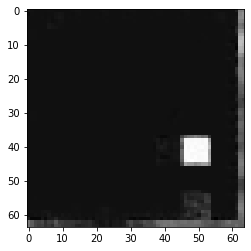

In [46]:
dim=(256,256)
im = cv2.imread("D:/1A work/jupyter/udac/LIVDET WORK/pred/greenbit/fake/528.JPG")
test_image=cv2.resize(im,dim)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image=normalize(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image = np.expand_dims(test_image, axis = 3)
pm=model.predict(test_image) 
f=model.predict(test_image) 
plt.imshow(f[0],cmap='gray')

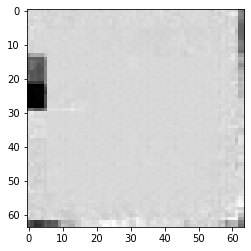

In [48]:
dim=(256,256)
im = cv2.imread("D:/1A work/jupyter/udac/LIVDET WORK/pred/greenbit/real/59.JPG")
test_image=cv2.resize(im,dim)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image=normalize(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image = np.expand_dims(test_image, axis = 3)
pm=model.predict(test_image) 
f=model.predict(test_image) 
plt.imshow(f[0],cmap='gray')